## Set up Environments

In [1]:
from ase.io.trajectory import TrajectoryWriter as tw
from ase.io.trajectory import TrajectoryReader as tr

import os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import InsetPosition

from publish_format import useLargeSize

/var/folders/s_/s1p_xb8n08x8djc3cxcpsm900000gn/T/ipykernel_8130/584238185.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import InsetPosition


## Some Useful functions

In [3]:
def extract_energy(filename):
    energy = []
    trajs = tr(filename)
    for traj in trajs:
        energy.append(traj.get_potential_energy())
    return np.array(energy)


def extract_forces_norm(filename):
    forces = []
    trajs = tr(filename)
    for traj in trajs:
        # forces.append(np.linalg.norm(np.array(traj.get_forces())))
        forces.append(traj.get_forces()[0])
    return np.array(forces)

def extract_forces(filename):
    forces = []
    trajs = tr(filename)
    for traj in trajs:
        forces.append(np.array(traj.get_forces()))
    return np.array(forces)

def extract_distance(filename, atom1, atom2):
    distances = []
    trajs = tr(filename)
    print(trajs[0].get_chemical_symbols())
    print("Get distance between atom {} and atom {}".format(atom1, atom2))
    for traj in trajs:
        distances.append(traj.get_distances(atom1, atom2)[0])
    return np.array(distances)

def extract_error_bar(filename):
    trajs = tr(filename)
    uncertainty = []
    for traj in trajs:
        uncertainty.append(traj.info["uncertainty"])
    return np.array(uncertainty)

## Comparison between DFT, AMPtorch DFT (with force) and AMPtorch DFT (without force) on Training dataset

In [4]:
dft_file = "./dft/widerange/dft_truncated.traj"
forces_dft = extract_forces_norm(dft_file)
forces_dft_mae = extract_forces(dft_file)
energies_dft = extract_energy(dft_file)
distances_dft = extract_distance(dft_file, 0, 1)

amptorch_dft_force_file = "./amptorch_dft/force/c2_amptorch_dft.traj"
forces_amptorch_dft_force = extract_forces_norm(amptorch_dft_force_file)
forces_amptorch_dft_force_mae = extract_forces(amptorch_dft_force_file)
energies_amptorch_dft_force = extract_energy(amptorch_dft_force_file)
distances_amptorch_dft_force = extract_distance(amptorch_dft_force_file, 0, 1)

amptorch_dft_noforce_file = "./amptorch_dft/noforce/check/c2_amptorch_dft.traj"
forces_amptorch_dft_noforce = extract_forces_norm(amptorch_dft_noforce_file)
forces_amptorch_dft_noforce_mae = extract_forces(amptorch_dft_noforce_file)
energies_amptorch_dft_noforce = extract_energy(amptorch_dft_noforce_file)
distances_amptorch_dft_noforce = extract_distance(amptorch_dft_noforce_file, 0, 1)

FileNotFoundError: [Errno 2] No such file or directory: 'dft/widerange/dft_truncated.traj'

In [51]:
for i in range(len(distances_dft)):
    print("{:.2f} {:.2f} {:.2f} {:.2f}".format(distances_dft[i][0], energies_dft[i], forces_dft[i], forces_amptorch_dft_force[i], forces_amptorch_dft_noforce[i]))

IndexError: invalid index to scalar variable.

In [ ]:
dft_traj = tr("./dft/widerange/dft.traj")[6:]
dft_truc_traj = tw("./dft/widerange/dft_truncated.traj")
for traj in dft_traj:
    dft_truc_traj.write(traj)
    
print(len(dft_traj))

### Energy comparison plot

In [ ]:
print(
    "MAE for amptorch DFT (force): \t energy {:.6f} \t force {:.6f}".format(
        np.sum(np.abs(energies_amptorch_dft_force - energies_dft))
        / len(energies_dft),
        np.mean(np.abs(forces_amptorch_dft_force_mae - forces_dft_mae)),
    )
)

print(
    "MAE for amptorch DFT (noforce):  energy {:.6f} \t force {:.6f}".format(
        np.sum(np.abs(energies_amptorch_dft_noforce - energies_dft))
        / len(energies_dft),
        np.mean(np.abs(forces_amptorch_dft_noforce_mae - forces_dft_mae)),
    )
)

print(
    len(energies_dft),
    len(energies_amptorch_dft_force),
    len(energies_amptorch_dft_noforce),
)

In [ ]:
energies_dft -= min(energies_dft)
energies_amptorch_dft_force -= min(energies_amptorch_dft_force)
energies_amptorch_dft_noforce -= min(energies_amptorch_dft_noforce)

In [ ]:
if not os.path.exists("./figures"):
    os.makedirs("./figures")

In [ ]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(distances_dft, energies_dft, marker="x", linestyle="dotted", markersize=8, c="k", label="DFT")
ax.scatter(distances_amptorch_dft_force, energies_amptorch_dft_force, marker="v", s=60, c="tab:orange", label="AMPtorch DFT (with force)")
ax.scatter(distances_amptorch_dft_noforce, energies_amptorch_dft_noforce, marker="^", s=60, c="tab:blue", label="AMPtorch DFT (without force)")



ax.set_xlabel(r"$d_{C-C}\ (\AA$)")
ax.set_ylabel(r"$E_{pot}\ (eV)$")
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(loc=0, frameon=False, fontsize=18)

ax2 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax, [0.56, 0.09, 0.4, 0.4])
# ip = inset_axes(ax, [0.56, 0.09, 0.4, 0.4])
start, end = 5, 19
ax2.set_axes_locator(ip)
ax2.plot(distances_dft[start:end], energies_dft[start:end], marker="x", linestyle="dotted", markersize=8, c="k", label="DFT")
ax2.scatter(distances_amptorch_dft_force[start:end], energies_amptorch_dft_force[start:end], marker="v", s=60, c="tab:orange", label="AMPtorch DFT (with force)")
ax2.scatter(distances_amptorch_dft_noforce[start:end], energies_amptorch_dft_noforce[start:end], marker="^", s=60, c="tab:blue", label="AMPtorch DFT (without force)")

ax2.yaxis.set_ticks_position("both")
ax2.xaxis.set_ticks_position("both")

useLargeSize(plt, ax)
useLargeSize(plt, ax2)

plt.savefig("./figures/c2_dft_energy_comparison.png", dpi=300)
plt.show()

### Energy parity plot

In [ ]:
plt.style.use('default')

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8), gridspec_kw={'height_ratios': [4, 1]})
fig.subplots_adjust(hspace=0)

axs[0].plot(energies_dft, energies_dft, linestyle="dotted", c="k", label="DFT")
axs[0].scatter(energies_dft, energies_amptorch_dft_force, marker="v", s=60, c="tab:orange", label="AMPtorch DFT (with force)")
axs[0].scatter(energies_dft, energies_amptorch_dft_noforce, marker="^", s=60, c="tab:blue", label="AMPtorch DFT (without force)")



axs[0].set_ylabel(r"$E_{pred}\ (eV)$")
axs[0].tick_params(axis="y")
axs[0].yaxis.set_ticks_position("both")
axs[0].xaxis.set_ticks_position("both")
axs[0].legend(loc=0, frameon=False, fontsize=18)

axs[1].plot(energies_dft, energies_dft - energies_dft, linestyle="dotted", c="k", label="DFT")
axs[1].scatter(energies_dft, (energies_amptorch_dft_force-energies_dft), marker="v", s=60, c="tab:orange", label="AMPtorch DFT (with force)")
axs[1].scatter(energies_dft, (energies_amptorch_dft_noforce-energies_dft), marker="^", s=60, c="tab:blue", label="AMPtorch DFT (without force)")


axs[1].set_xlabel(r"$E_{DFT}\ (eV)$")
axs[1].set_ylabel(r"$E_{pred} - E_{DFT}\ (eV)$")

axs[0].xaxis.set_ticks_position("both")
axs[0].yaxis.set_ticks_position("both")
axs[1].xaxis.set_ticks_position("both")
axs[1].yaxis.set_ticks_position("both")
useLargeSize(plt, axs[0])
useLargeSize(plt, axs[1])

plt.tight_layout()
plt.savefig("./figures/c2_dft_energy_parity.png", dpi=300)
plt.show()

### Force comparison plot

In [ ]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(distances_dft, forces_dft, marker="x", linestyle="dotted", markersize=8, c="k", label="DFT")
ax.scatter(distances_amptorch_dft_force, forces_amptorch_dft_force, marker="v", s=60, c="tab:orange", label="AMPtorch DFT (with force)")
ax.scatter(distances_amptorch_dft_noforce, forces_amptorch_dft_noforce, marker="^", s=60, c="tab:blue", label="AMPtorch DFT (without force)")



ax.set_xlabel(r"$d_{C-C}\ (\AA$)")
ax.set_ylabel(r"$F\, (eV\cdot\AA^{-1})$")
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(loc=0, frameon=False, fontsize=18)

ax2 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax, [0.4, 0.2, 0.55, 0.5])
start, end = 5, 19
ax2.set_axes_locator(ip)
ax2.plot(distances_dft[start:end], forces_dft[start:end], marker="x", linestyle="dotted", markersize=8, c="k", label="DFT")
ax2.scatter(distances_amptorch_dft_force[start:end], forces_amptorch_dft_force[start:end], marker="v", s=60, c="tab:orange", label="AMPtorch DFT (with force)")
ax2.scatter(distances_amptorch_dft_noforce[start:end], forces_amptorch_dft_noforce[start:end], marker="^", s=60, c="tab:blue", label="AMPtorch DFT (without force)")


ax2.yaxis.set_ticks_position("both")
ax2.xaxis.set_ticks_position("both")

useLargeSize(plt, ax)
useLargeSize(plt, ax2)

plt.savefig("./figures/c2_dft_force_comparison.png", dpi=300)
plt.show()

### Force parity plot

In [ ]:
plt.style.use('default')

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8), gridspec_kw={'height_ratios': [4, 1]})
fig.subplots_adjust(hspace=0)

axs[0].plot(forces_dft_mae.flatten(), forces_dft_mae.flatten(), linestyle="dotted", c="k", label="DFT")
axs[0].scatter(forces_dft_mae.flatten(), forces_amptorch_dft_force_mae.flatten(), marker="v", s=60, c="tab:orange", label="AMPtorch DFT (with force)")
axs[0].scatter(forces_dft_mae.flatten(), forces_amptorch_dft_noforce_mae.flatten(), marker="^", s=60, c="tab:blue", label="AMPtorch DFT (without force)")

axs[0].set_ylabel(r"$F_{pred}\ (eV\cdot\AA^{-1}$)")
axs[0].tick_params(axis="y")
axs[0].yaxis.set_ticks_position("both")
axs[0].xaxis.set_ticks_position("both")
axs[0].legend(loc=0, frameon=False, fontsize=18)

axs[1].plot(forces_dft_mae.flatten(), forces_dft_mae.flatten() - forces_dft_mae.flatten(), linestyle="dotted", c="k", label="DFT")
axs[1].scatter(forces_dft_mae.flatten(), forces_amptorch_dft_force_mae.flatten()-forces_dft_mae.flatten(), marker="v", s=60, c="tab:orange", label="AMPtorch DFT (with force)")
axs[1].scatter(forces_dft_mae.flatten(), forces_amptorch_dft_noforce_mae.flatten()-forces_dft_mae.flatten(), marker="^", s=60, c="tab:blue", label="AMPtorch DFT (without force)")


axs[1].set_xlabel(r"$F_{DFT}\,(eV\cdot\AA^{-1}$)")
axs[1].set_ylabel(r"${F_{pred} - F_{DFT}}\,(eV\cdot\AA^{-1})$")

axs[1].yaxis.set_ticks_position("both")
axs[1].xaxis.set_ticks_position("both")

useLargeSize(plt, axs[0])
useLargeSize(plt, axs[1])

plt.savefig("./figures/c2_dft_force_parity.png", dpi=300)
plt.show()

## Comparison between DFT, AMPtorch DFT (with force) and AMPtorch DFT (without force) on Test  dataset

In [ ]:
nexus_dft_traj_file = "/users/chuang25/data/chuang25/github_repo/ml_qmc_force/examples/c2/dft/widerange/dft.traj"
ase_dft_traj_file = "/users/chuang25/data/chuang25/github_repo/ml_qmc_force/examples/c2/dft/widerange_test/dft_train.traj"

nexus_forces_dft = extract_forces(nexus_dft_traj_file)[6:]
nexus_energies_dft = extract_energy(nexus_dft_traj_file)[6:]
nexus_distances_dft = extract_distance(nexus_dft_traj_file, 0, 1)[6:]

ase_forces_dft = extract_forces(ase_dft_traj_file)[6:]
ase_energies_dft = extract_energy(ase_dft_traj_file)[6:]
ase_distances_dft = extract_distance(ase_dft_traj_file, 0, 1)[6:]

print(len(nexus_energies_dft), len(ase_energies_dft))

length = min(len(nexus_energies_dft), len(ase_energies_dft))
nexus_energies_dft = nexus_energies_dft[:length]
ase_energies_dft = ase_energies_dft[:length]

print(np.mean(ase_energies_dft-nexus_energies_dft))

plt.style.use('default')

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8), gridspec_kw={'height_ratios': [4, 1]})
fig.subplots_adjust(hspace=0)

axs[0].plot(nexus_energies_dft, nexus_energies_dft, linestyle="dotted", c="k")
axs[0].scatter(nexus_energies_dft, nexus_energies_dft, marker="^", s=60, c="tab:blue", label="Nexus")
axs[0].scatter(nexus_energies_dft, ase_energies_dft, marker="v", s=60, c="r", label="ASE")
axs[0].set_ylabel(r"$E_{pot}\,(eV)$")
axs[0].tick_params(axis="y")
axs[0].yaxis.set_ticks_position("both")
axs[0].xaxis.set_ticks_position("both")
axs[0].legend(loc=0, frameon=False, fontsize=18)

axs[1].plot(nexus_energies_dft, nexus_energies_dft - nexus_energies_dft, linestyle="dotted", c="k")
axs[1].scatter(nexus_energies_dft, (nexus_energies_dft-nexus_energies_dft),  marker="^", s=60, c="tab:blue", label="ASE")
axs[1].scatter(nexus_energies_dft, (ase_energies_dft-nexus_energies_dft),  marker="v", s=60, c="r", label="ASE")
axs[1].set_xlabel(r"$E_{Nexus}\ (eV)$")
axs[1].set_ylabel(r"$\Delta_{E_{pot} - E_{Nexus}}\ (eV)$")

useLargeSize(plt, axs[0])
useLargeSize(plt, axs[1])

plt.tight_layout()
plt.savefig("./figures/c2_compare_nexus_and_ase_dft_results.png", dpi=300)
plt.show()

In [ ]:
test_dft_file = "./dft/widerange_test/dft_final.traj"
test_forces_dft = extract_forces_norm(test_dft_file)[5:]
test_forces_dft_mae = extract_forces(test_dft_file)[5:]
test_energies_dft = extract_energy(test_dft_file)[5:]
test_distances_dft = extract_distance(test_dft_file, 0, 1)[5:]

test_amptorch_dft_force_file = "./amptorch_dft/force/test_amptorch/c2_amptorch_dft.traj"
test_forces_amptorch_dft_force = extract_forces_norm(test_amptorch_dft_force_file)[5:]
test_forces_amptorch_dft_force_mae = extract_forces(test_amptorch_dft_force_file)[5:]
test_energies_amptorch_dft_force = extract_energy(test_amptorch_dft_force_file)[5:]
test_distances_amptorch_dft_force = extract_distance(test_amptorch_dft_force_file, 0, 1)[5:]

test_amptorch_dft_noforce_file = "./amptorch_dft/noforce/test_amptorch/c2_amptorch_dft.traj"
test_forces_amptorch_dft_noforce = extract_forces_norm(test_amptorch_dft_noforce_file)[5:]
test_forces_amptorch_dft_noforce_mae = extract_forces(test_amptorch_dft_noforce_file)[5:]
test_energies_amptorch_dft_noforce = extract_energy(test_amptorch_dft_noforce_file)[5:]
test_distances_amptorch_dft_noforce = extract_distance(test_amptorch_dft_noforce_file, 0, 1)[5:]

print(min(test_distances_dft), max(test_distances_dft))

In [ ]:
print(
    "MAE for amptorch DFT (force): \t energy {:.6f} \t force {:.6f}".format(
        np.sum(np.abs(test_energies_amptorch_dft_force - test_energies_dft))
        / len(test_energies_dft),
        np.mean(np.abs(test_forces_amptorch_dft_force_mae - test_forces_dft_mae))
    )
)

print(
    "MAE for amptorch DFT (noforce):  energy {:.6f} \t force {:.6f}".format(
        np.sum(np.abs(test_energies_amptorch_dft_noforce - test_energies_dft))
        / len(test_energies_dft),
        np.mean(np.abs(test_forces_amptorch_dft_noforce_mae - test_forces_dft_mae))
    )
)

print(
    len(test_energies_dft),
    len(test_energies_amptorch_dft_force),
    len(test_energies_amptorch_dft_noforce),
)

In [ ]:
test_energies_dft -= min(test_energies_dft)
test_energies_amptorch_dft_force -= min(test_energies_amptorch_dft_force)
test_energies_amptorch_dft_noforce -= min(test_energies_amptorch_dft_noforce)

In [ ]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(test_distances_dft, test_energies_dft, marker="x", linestyle="dotted", markersize=8, c="k", label="DFT")
ax.scatter(test_distances_amptorch_dft_force, test_energies_amptorch_dft_force, marker="v", s=60, c="tab:orange", label="AMPtorch DFT \n(with force)")
ax.scatter(test_distances_amptorch_dft_noforce, test_energies_amptorch_dft_noforce, marker="^", s=60, c="tab:blue", label="AMPtorch DFT \n(without force)")



ax.set_xlabel(r"$d_{C-C}\,(\AA$)")
ax.set_ylabel(r"$E_{pot}\,(eV)$")
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(loc=(0.1, 0.65), frameon=False, fontsize=18)

ax2 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax, [0.46, 0.10, 0.5, 0.43])
# ip = inset_axes(ax, [0.56, 0.09, 0.4, 0.4])
start, end = 3, 16
ax2.set_axes_locator(ip)
ax2.plot(test_distances_dft[start:end], test_energies_dft[start:end], marker="x", linestyle="dotted", markersize=8, c="k", label="DFT")
ax2.scatter(test_distances_amptorch_dft_force[start:end], test_energies_amptorch_dft_force[start:end], marker="v", s=60, c="tab:orange", label="AMPtorch DFT (with force)")
ax2.scatter(test_distances_amptorch_dft_noforce[start:end], test_energies_amptorch_dft_noforce[start:end], marker="^", s=60, c="tab:blue", label="AMPtorch DFT (without force)")


ax2.yaxis.set_ticks_position("both")
ax2.xaxis.set_ticks_position("both")

useLargeSize(plt, ax)
useLargeSize(plt, ax2)

plt.savefig("./figures/c2_dft_energy_comparison_test.png", dpi=300)
plt.show()

In [ ]:
plt.style.use('default')

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8), gridspec_kw={'height_ratios': [4, 1]})
fig.subplots_adjust(hspace=0)

axs[0].plot(test_energies_dft, test_energies_dft, linestyle="dotted", c="k", label="DFT")
axs[0].scatter(test_energies_dft, test_energies_amptorch_dft_force, marker="v", s=60, c="tab:orange", label="AMPtorch DFT (with force)")
axs[0].scatter(test_energies_dft, test_energies_amptorch_dft_noforce, marker="^", s=60, c="tab:blue", label="AMPtorch DFT (without force)")



axs[0].set_ylabel(r"$E_{pred}\,(eV)$")
axs[0].tick_params(axis="y")
axs[0].yaxis.set_ticks_position("both")
axs[0].xaxis.set_ticks_position("both")
axs[0].legend(loc=0, frameon=False, fontsize=18)

axs[1].plot(test_energies_dft, test_energies_dft - test_energies_dft, linestyle="dotted", c="k", label="DFT")
axs[1].scatter(test_energies_dft, (test_energies_amptorch_dft_force-test_energies_dft), marker="v", s=60, c="tab:orange", label="AMPtorch DFT (with force)")
axs[1].scatter(test_energies_dft, (test_energies_amptorch_dft_noforce-test_energies_dft), marker="^", s=60, c="tab:blue", label="AMPtorch DFT (without force)")


axs[1].set_xlabel(r"$E_{DFT}\,(eV)$")
axs[1].set_ylabel(r"${E_{pred} - E_{DFT}}\,(eV)$")
axs[1].yaxis.set_ticks_position("both")
axs[1].xaxis.set_ticks_position("both")
useLargeSize(plt, axs[0])
useLargeSize(plt, axs[1])

plt.tight_layout()
plt.savefig("./figures/c2_dft_energy_parity_test.png", dpi=300)
plt.show()

In [ ]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(test_distances_dft, test_forces_dft, marker="x", linestyle="dotted", markersize=8, c="k", label="DFT")
ax.scatter(test_distances_amptorch_dft_force, test_forces_amptorch_dft_force, marker="v", s=60, c="tab:orange", label="AMPtorch DFT (with force)")
ax.scatter(test_distances_amptorch_dft_noforce, test_forces_amptorch_dft_noforce, marker="^", s=60, c="tab:blue", label="AMPtorch DFT (without force)")



ax.set_xlabel(r"$d_{C-C}\,(\AA$)")
ax.set_ylabel(r"$F\,(eV\cdot\AA^{-1}$)")
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(loc=0, frameon=False, fontsize=18)

ax2 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax, [0.4, 0.2, 0.55, 0.5])
start, end = 3, 16
ax2.set_axes_locator(ip)
ax2.plot(test_distances_dft[start:end], test_forces_dft[start:end], marker="x", linestyle="dotted", markersize=8, c="k", label="DFT")
ax2.scatter(test_distances_amptorch_dft_force[start:end], test_forces_amptorch_dft_force[start:end], marker="v", s=60, c="tab:orange", label="AMPtorch DFT (with force)")
ax2.scatter(test_distances_amptorch_dft_noforce[start:end], test_forces_amptorch_dft_noforce[start:end], marker="^", s=60, c="tab:blue", label="AMPtorch DFT (without force)")


ax2.yaxis.set_ticks_position("both")
ax2.xaxis.set_ticks_position("both")
useLargeSize(plt, ax)
useLargeSize(plt, ax2)

plt.savefig("./figures/c2_dft_force_comparison_test.png", dpi=300)
plt.show()

In [ ]:
plt.style.use('default')

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8), gridspec_kw={'height_ratios': [4, 1]})
fig.subplots_adjust(hspace=0)

axs[0].plot(test_forces_dft_mae.flatten(), test_forces_dft_mae.flatten(), linestyle="dotted", c="k", label="DFT")
axs[0].scatter(test_forces_dft_mae.flatten(), test_forces_amptorch_dft_force_mae.flatten(), marker="v", s=60, c="tab:orange", label="AMPtorch DFT (with force)")
axs[0].scatter(test_forces_dft_mae.flatten(), test_forces_amptorch_dft_noforce_mae.flatten(), marker="^", s=60, c="tab:blue", label="AMPtorch DFT (without force)")



axs[0].set_ylabel(r"$F_{pred}\,(eV\cdot\AA^{-1}$)")
axs[0].tick_params(axis="y")
axs[0].yaxis.set_ticks_position("both")
axs[0].xaxis.set_ticks_position("both")
axs[0].legend(loc=0, frameon=False, fontsize=18)

axs[1].plot(test_forces_dft_mae.flatten(), test_forces_dft_mae.flatten() - test_forces_dft_mae.flatten(), linestyle="dotted", c="k", label="DFT")
axs[1].scatter(test_forces_dft_mae.flatten(), test_forces_amptorch_dft_force_mae.flatten() - test_forces_dft_mae.flatten(), marker="v", s=60, c="tab:orange", label="AMPtorch DFT (with force)")
axs[1].scatter(test_forces_dft_mae.flatten(), test_forces_amptorch_dft_noforce_mae.flatten() - test_forces_dft_mae.flatten(), marker="^", s=60, c="tab:blue", label="AMPtorch DFT (without force)")


axs[1].yaxis.set_ticks_position("both")
axs[1].xaxis.set_ticks_position("both")
axs[1].set_xlabel(r"$F_{DFT}\,(eV\cdot\AA^{-1})$")
axs[1].set_ylabel(r"$F_{pred} - F_{DFT}\,(eV\cdot\AA^{-1})$")

useLargeSize(plt, axs[0])
useLargeSize(plt, axs[1])

plt.savefig("./figures/c2_dft_force_parity_test.png", dpi=300)
plt.show()

## Comparison between DFT, AMPtorch-DFT, DMC, AMPtorch-DMC on Training dataset

In [ ]:
dft_file = "./dft/widerange/dft_truncated.traj"
forces_dft = extract_forces_norm(dft_file)
forces_dft_mae = extract_forces(dft_file)
energies_dft = extract_energy(dft_file)
distances_dft = extract_distance(dft_file, 0, 1)

amptorch_dft_noforce_file = "./amptorch_dft/noforce/check/c2_amptorch_dft.traj"
forces_amptorch_dft_noforce = extract_forces_norm(amptorch_dft_noforce_file)
forces_amptorch_dft_noforce_mae = extract_forces(amptorch_dft_noforce_file)
energies_amptorch_dft_noforce = extract_energy(amptorch_dft_noforce_file)
distances_amptorch_dft_noforce = extract_distance(amptorch_dft_noforce_file, 0, 1)

dmc_file = "./dmc/walker4_widerrange/dmc_truncated.traj"
# forces_dmc = extract_forces(dmc_file)
energies_dmc = extract_energy(dmc_file)
distances_dmc = extract_distance(dmc_file, 0, 1)
uncertainties = extract_error_bar(dmc_file)

amptorch_dmc_file = "./amptorch_dmc/calculate_force_train/c2_amptorch_dmc.traj"
forces_amptorch_dmc = extract_forces_norm(amptorch_dmc_file)
forces_amptorch_dmc_mae = extract_forces(amptorch_dmc_file)
energies_amptorch_dmc = extract_energy(amptorch_dmc_file)
distances_amptorch_dmc = extract_distance(amptorch_dmc_file, 0, 1)

In [ ]:
print(min(energies_amptorch_dmc))

In [ ]:
dft_traj = tr("./dmc/walker4_widerrange/dmc.traj")[6:]
dft_truc_traj = tw("./dmc/walker4_widerrange/dmc_truncated.traj")
for traj in dft_traj:
    dft_truc_traj.write(traj)

### Energy comparison plot

In [ ]:
print(
    "MAE for amptorch DMC : \t\t energies: {:.6f} \t forces: NA".format(
        np.sum(np.abs(energies_amptorch_dmc - energies_dmc))
        / len(energies_dmc),
    )
)

print(
    "MAE for amptorch DFT (noforce):  energies: {:.6f} \t forces: {:.6f}".format(
        np.sum(np.abs(energies_amptorch_dft_noforce - energies_dft))
        / len(energies_dft),
        np.sum(np.abs(forces_amptorch_dft_noforce - forces_dft))
        / len(energies_dft),
    )
)

print(
    len(energies_dft),
    len(energies_amptorch_dft_force),
    len(energies_amptorch_dft_noforce),
)

In [ ]:
energies_dft -= min(energies_dft)
energies_amptorch_dft_noforce -= min(energies_amptorch_dft_noforce)
energies_dmc -= min(energies_dmc)
energies_amptorch_dmc -= min(energies_amptorch_dmc)

In [ ]:
print(distances_dmc.flatten())
print(energies_amptorch_dmc - energies_dmc)
print(energies_dft - energies_dmc)

In [ ]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(distances_dft, energies_dft, linestyle="dotted", markersize=8, marker="x", c="k", label="DFT")
ax.scatter(distances_amptorch_dft_noforce, energies_amptorch_dft_noforce, marker="^", s=60, c="tab:blue", label="AMPtorch DFT\n(without force)")
ax.errorbar(distances_dmc, energies_dmc, yerr=uncertainties, ecolor="k", capsize=7, c="darkorange", fmt=".", linestyle="dashdot", label="DMC")
ax.scatter(distances_amptorch_dmc, energies_amptorch_dmc, marker="d", s=60, c="tab:red", label="AMPtorch DMC")


ax.set_xlabel(r"$d_{C-C}\,(\AA$)")
ax.set_ylabel(r"$E_{pot}\,(eV)$")
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.set_ylim(-1.0, 18)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[1], handles[3], handles[2]]
labels = [labels[0], labels[1], labels[3], labels[2]]
ax.legend(handles,labels, loc=(0.6, 0.0), frameon=False, fontsize=18)

ax2 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax, [0.18, 0.57, 0.6, 0.4])
# ip = inset_axes(ax, [0.56, 0.09, 0.4, 0.4])
start, end = 5, 21
ax2.set_axes_locator(ip)
ax2.plot(distances_dft[start:end], energies_dft[start:end], linestyle="dotted", markersize=8, marker="x", c="k", label="DFT")
ax2.scatter(distances_amptorch_dft_noforce[start:end], energies_amptorch_dft_noforce[start:end], marker="^", s=60, c="tab:blue", label="AMPtorch DFT\n(without force)")
ax2.errorbar(distances_dmc[start:end], energies_dmc[start:end], yerr=uncertainties[start:end], ecolor="k", capsize=7, c="darkorange", fmt=".", linestyle="dashdot", label="DMC")
ax2.scatter(distances_amptorch_dmc[start:end], energies_amptorch_dmc[start:end], marker="d", s=60, c="tab:red", label="AMPtorch DMC")
ax2.yaxis.set_ticks_position("both")
ax2.xaxis.set_ticks_position("both")
useLargeSize(plt, ax)
useLargeSize(plt, ax2)

plt.savefig("./figures/c2_dmc_energy_comparison.png", dpi=300)
plt.show()

### DMC Energy parity plots

In [ ]:
plt.style.use('default')

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8), gridspec_kw={'height_ratios': [4, 1]})
fig.subplots_adjust(hspace=0)

axs[0].errorbar(energies_dmc, energies_dmc, yerr=uncertainties, ecolor="k", capsize=7, c="darkorange", fmt=".", linestyle="dashdot", label="DMC")
axs[0].scatter(energies_dmc, energies_amptorch_dmc, marker="d", s=60, c="tab:red", label="AMPtorch DMC")

axs[0].set_ylabel(r"$E_{pred}\,(eV)$")
axs[0].tick_params(axis="y")
axs[0].yaxis.set_ticks_position("both")
axs[0].xaxis.set_ticks_position("both")
handles,labels = axs[0].get_legend_handles_labels()
handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]
axs[0].legend(handles, labels, loc=0, frameon=False, fontsize=18)

axs[1].errorbar(energies_dmc, energies_dmc-energies_dmc, yerr=uncertainties, ecolor="k", capsize=7, c="darkorange", fmt=".", linestyle="dashdot", label="DMC")
axs[1].scatter(energies_dmc, (energies_amptorch_dmc-energies_dmc), marker="d", s=60, c="tab:red", label="AMPtorch DMC")

axs[1].set_xlabel(r"$E_{DMC}\,(eV)$")
axs[1].set_ylabel(r"$E_{pred} - E_{DMC}\,(eV)$")
axs[1].yaxis.set_ticks_position("both")
axs[1].xaxis.set_ticks_position("both")
useLargeSize(plt, axs[0])
useLargeSize(plt, axs[1])

plt.savefig("./figures/c2_dmc_energy_parity.png", dpi=300)
plt.show()

### Force comparison between DFT, AMPtorch DFT and AMPtorch DMC

Not sure if we need this comparion as the forces are calculated by different methods.

In [ ]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(distances_dft, forces_dft, linestyle="dotted", markersize=8, marker="x", c="k", label="DFT")
ax.scatter(distances_amptorch_dft_noforce, forces_amptorch_dft_noforce,  marker="^", s=60, c="tab:blue", label="AMPtorch DFT\n(without force)")
ax.scatter(distances_amptorch_dmc, forces_amptorch_dmc, marker="d", s=60, c="tab:red", label="AMPtorch DMC")


ax.set_xlabel(r"$d_{C-C}\,(\AA$)")
ax.set_ylabel(r"$F\,(eV\cdot\AA^{-1}$)")
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(loc=0, frameon=False, fontsize=18)

ax2 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax, [0.35, 0.2, 0.6, 0.5])
start, end = 5, 21
ax2.set_axes_locator(ip)
ax2.plot(distances_dft[start:end], forces_dft[start:end], linestyle="dotted", markersize=8, marker="x", c="k", label="DFT")
ax2.scatter(distances_amptorch_dft_noforce[start:end], forces_amptorch_dft_noforce[start:end], marker="^", s=60, c="tab:blue", label="AMPtorch DFT\n(without force)")
ax2.scatter(distances_amptorch_dft_force[start:end], forces_amptorch_dmc[start:end], marker="d", s=60, c="tab:red", label="AMPtorch DMC")

ax2.yaxis.set_ticks_position("both")
ax2.xaxis.set_ticks_position("both")
useLargeSize(plt, ax)
useLargeSize(plt, ax2)

plt.savefig("./figures/c2_dmc_force_comparison.png", dpi=300)
plt.show()

## Comparison between DFT, AMPtorch-DFT, DMC, AMPtorch-DMC on Test dataset

In [52]:
test_dft_file = "./dft/widerange_test/dft_final.traj"
test_forces_dft = extract_forces(test_dft_file)[5:]
test_energies_dft = extract_energy(test_dft_file)[5:]
test_distances_dft = extract_distance(test_dft_file, 0, 1)[5:]

test_amptorch_dft_noforce_file = "./amptorch_dft/noforce/test_amptorch/c2_amptorch_dft.traj"
test_forces_amptorch_dft_noforce = extract_forces(test_amptorch_dft_noforce_file)[5:]
test_energies_amptorch_dft_noforce = extract_energy(test_amptorch_dft_noforce_file)[5:]
test_distances_amptorch_dft_noforce = extract_distance(test_amptorch_dft_noforce_file, 0, 1)[5:]

test_dmc_file = "./test_dataset/DMC/dmc.traj"
# forces_dmc = extract_forces(dmc_file)
test_energies_dmc = extract_energy(test_dmc_file)[5:]
test_distances_dmc = extract_distance(test_dmc_file, 0, 1)[5:]
test_uncertainties = extract_error_bar(test_dmc_file)[5:]

test_amptorch_dmc_file = "./amptorch_dmc/test/c2_amptorch_dmc.traj"
test_forces_amptorch_dmc = extract_forces(test_amptorch_dmc_file)[5:]
test_energies_amptorch_dmc = extract_energy(test_amptorch_dmc_file)[5:]
test_distances_amptorch_dmc = extract_distance(test_amptorch_dmc_file, 0, 1)[5:]

['C', 'C']
Get distance between atom 0 and atom 1
['C', 'C']
Get distance between atom 0 and atom 1
['C', 'C']
Get distance between atom 0 and atom 1
['C', 'C']
Get distance between atom 0 and atom 1


In [53]:
print(len(test_energies_dft), len(test_energies_amptorch_dft_noforce), len(test_energies_dmc), len(test_energies_amptorch_dmc))

55 55 55 55


In [57]:
test_energies_dft -= min(test_energies_dft)
test_energies_amptorch_dft_noforce -= min(test_energies_amptorch_dft_noforce)
test_energies_dmc -= min(test_energies_dmc)
test_energies_amptorch_dmc -= min(test_energies_amptorch_dmc)

In [54]:
def calculate_mae(true, pred):
    return np.mean(np.abs(true - pred))

In [55]:
print(calculate_mae(test_energies_dft, test_energies_amptorch_dft_noforce))
print(calculate_mae(test_energies_dmc, test_energies_amptorch_dmc))

0.08595704233569822
0.09440184115767145


/users/chuang25/data/chuang25/local/util/publish_format.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


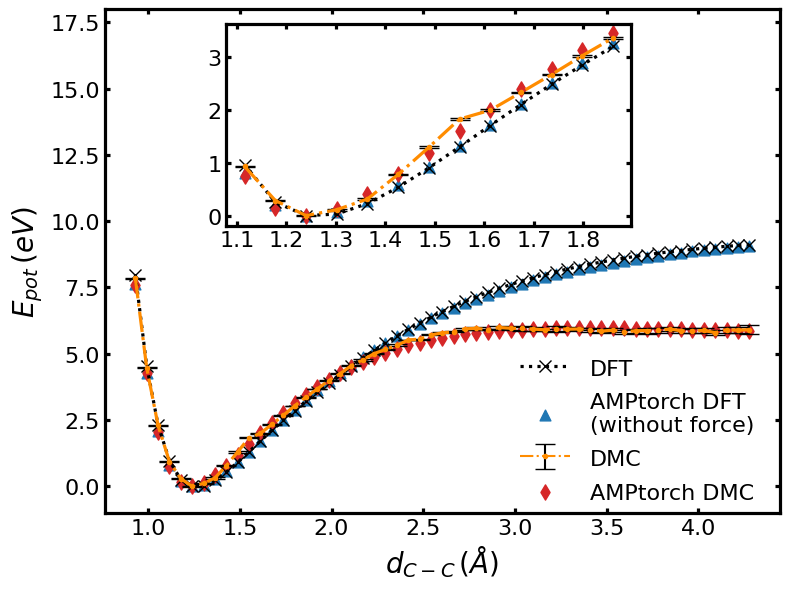

In [59]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(test_distances_dft, test_energies_dft, linestyle="dotted", markersize=8, marker="x", c="k", label="DFT")
ax.scatter(test_distances_amptorch_dft_noforce, test_energies_amptorch_dft_noforce, marker="^", s=60, c="tab:blue", label="AMPtorch DFT\n(without force)")
ax.errorbar(test_distances_dmc, test_energies_dmc, yerr=test_uncertainties, ecolor="k", capsize=7, c="darkorange", fmt=".", linestyle="dashdot", label="DMC")
ax.scatter(test_distances_amptorch_dmc, test_energies_amptorch_dmc, marker="d", s=60, c="tab:red", label="AMPtorch DMC")

ax.set_xlabel(r"$d_{C-C}\,(\AA$)")
ax.set_ylabel(r"$E_{pot}\,(eV)$")
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.set_ylim(-1.0, 18)
handles,labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[1], handles[3], handles[2]]
labels = [labels[0], labels[1], labels[3], labels[2]]
ax.legend(handles,labels, loc=(0.6, 0.0), frameon=False, fontsize=18)


ax2 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax, [0.18, 0.57, 0.6, 0.4])
# ip = inset_axes(ax, [0.56, 0.09, 0.4, 0.4])
start, end = 3, 16
ax2.set_axes_locator(ip)
ax2.plot(test_distances_dft[start:end], test_energies_dft[start:end], linestyle="dotted", markersize=8, marker="x", c="k", label="DFT")
ax2.scatter(test_distances_amptorch_dft_noforce[start:end], test_energies_amptorch_dft_noforce[start:end],marker="^", s=60, c="tab:blue", label="AMPtorch DFT\n(without force)")
ax2.errorbar(test_distances_dmc[start:end], test_energies_dmc[start:end], yerr=test_uncertainties[start:end], ecolor="k", capsize=7, c="darkorange", fmt=".", linestyle="dashdot", label="DMC")
ax2.scatter(test_distances_amptorch_dmc[start:end], test_energies_amptorch_dmc[start:end], marker="d", s=60, c="tab:red", label="AMPtorch DMC")

ax2.yaxis.set_ticks_position("both")
ax2.xaxis.set_ticks_position("both")

useLargeSize(plt, ax)
useLargeSize(plt, ax2)

plt.savefig("./figures/c2_dmc_energy_comparison_test.png", dpi=300)
plt.show()

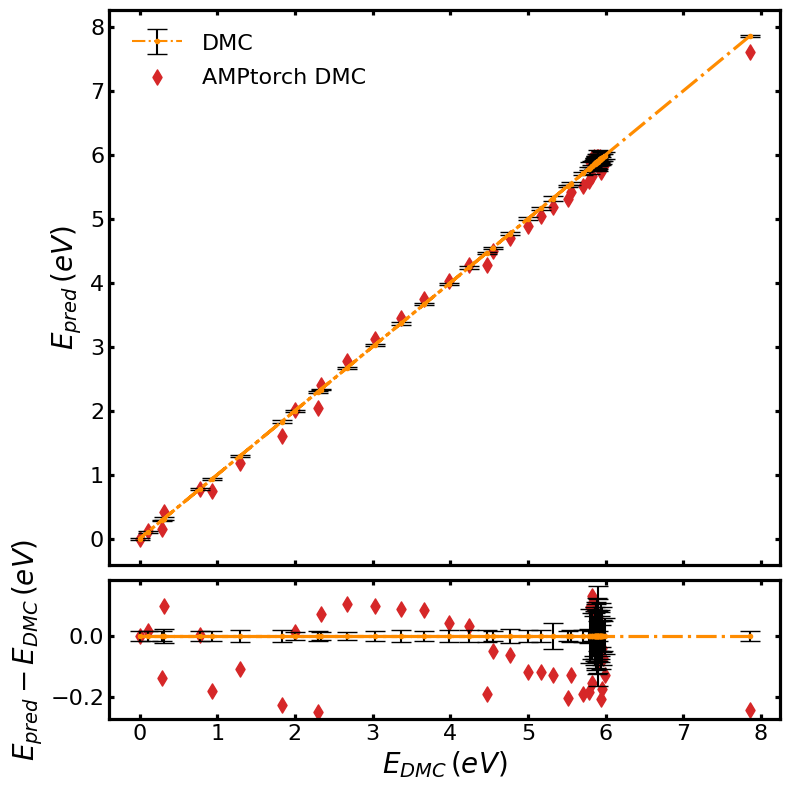

In [60]:
plt.style.use('default')

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8), gridspec_kw={'height_ratios': [4, 1]})
fig.subplots_adjust(hspace=0)

axs[0].errorbar(test_energies_dmc, test_energies_dmc, yerr=test_uncertainties, ecolor="k", capsize=7, c="darkorange", fmt=".", linestyle="dashdot", label="DMC")
axs[0].scatter(test_energies_dmc, test_energies_amptorch_dmc, marker="d", s=60, c="tab:red", label="AMPtorch DMC")

axs[0].set_ylabel(r"$E_{pred}\,(eV)$")
axs[0].tick_params(axis="y")
axs[0].yaxis.set_ticks_position("both")
axs[0].xaxis.set_ticks_position("both")
handles,labels = axs[0].get_legend_handles_labels()
handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]
axs[0].legend(handles, labels, loc=0, frameon=False, fontsize=18)

axs[1].errorbar(test_energies_dmc, test_energies_dmc-test_energies_dmc, yerr=test_uncertainties, ecolor="k", capsize=7, c="darkorange", fmt=".", linestyle="dashdot", label="DMC")
axs[1].scatter(test_energies_dmc, (test_energies_amptorch_dmc-test_energies_dmc), marker="d", s=60, c="tab:red", label="AMPtorch DMC")

axs[1].set_xlabel(r"$E_{DMC}\,(eV)$")
axs[1].set_ylabel(r"$E_{pred} - E_{DMC}\,(eV)$")

axs[1].yaxis.set_ticks_position("both")
axs[1].xaxis.set_ticks_position("both")
useLargeSize(plt, axs[0])
useLargeSize(plt, axs[1])

plt.savefig("./figures/c2_dmc_energy_parity_test.png", dpi=300)
plt.show()

ValueError: x and y can be no greater than 2-D, but have shapes (55,) and (55, 2, 3)

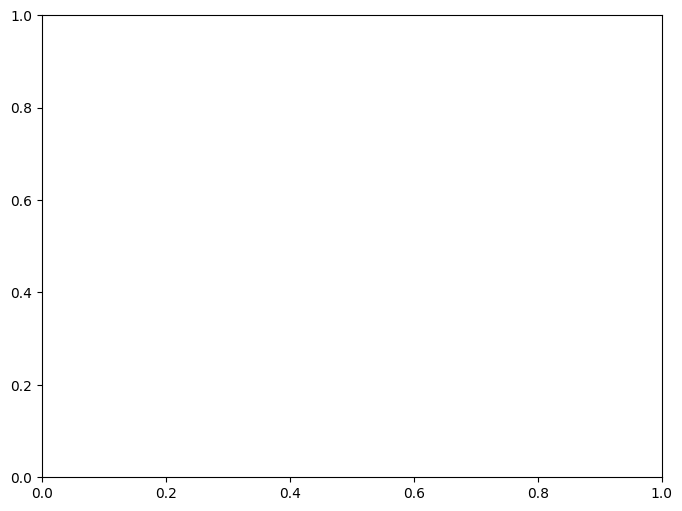

In [61]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(test_distances_dft, test_forces_dft, linestyle="dotted", markersize=8, marker="x", c="k", label="DFT")
ax.scatter(test_distances_amptorch_dft_noforce, test_forces_amptorch_dft_noforce, marker="^", s=60, c="tab:blue", label="AMPtorch DFT\n(without force)")
ax.scatter(test_distances_amptorch_dmc, test_forces_amptorch_dmc, marker="d", s=60, c="tab:red", label="AMPtorch DMC")

ax.set_xlabel(r"$d_{C-C}\,(\AA$)")
ax.set_ylabel(r"$F\,(eV\cdot\AA^{-1}$)")
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(loc=0, frameon=False, fontsize=18)

ax2 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax, [0.35, 0.2, 0.6, 0.5])
start, end = 3, 16
ax2.set_axes_locator(ip)
ax2.plot(test_distances_dft[start:end], test_forces_dft[start:end], linestyle="dotted", markersize=8, marker="x", c="k", label="DFT")
ax2.scatter(test_distances_amptorch_dft_noforce[start:end], test_forces_amptorch_dft_noforce[start:end], marker="^", s=60, c="tab:blue", label="AMPtorch DFT\n(without force)")
ax2.scatter(test_distances_amptorch_dmc[start:end], test_forces_amptorch_dmc[start:end], marker="d", s=60, c="tab:red", label="AMPtorch DMC")
ax2.yaxis.set_ticks_position("both")
ax2.xaxis.set_ticks_position("both")
useLargeSize(plt, ax)
useLargeSize(plt, ax2)

plt.savefig("./figures/c2_dmc_force_comparison_test.png", dpi=300)
plt.show()